# 3 Sample Tests Power over Increasing Epsilon

These are same useful functions to import. Since we are calculating the statistical power over all the tests for all the simulations, we can just use a wild card import from the respective modules

In [1]:
import sys, os
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend import Legend

from benchmarks import power_3samp_epsweight
from hyppo.independence import Dcorr, Hsic, MGC
from hyppo.sims import gaussian_3samp

sys.path.append(os.path.realpath('..'))

In [4]:
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=2)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])

In [5]:
from statsmodels.multivariate.manova import MANOVA


class PyManova:
    r"""
    Wrapper of statsmodels MANOVA
    """

    def _statistic(self, x, y):
        r"""
        Helper function to calculate the test statistic
        """
        stat = MANOVA(x, y).mv_test().results['x0']['stat'].values[1, 0]
        self.stat = stat

        return stat

In [6]:
from rpy2.robjects import Formula, numpy2ri
from rpy2.robjects.packages import importr


class Manova:
    r"""
    Wrapper of R MANOVA
    """
    def __init__(self):
        self.stats = importr('stats')
        self.r_base = importr('base')
        
        numpy2ri.activate()

        self.formula = Formula('X ~ Y')
        self.env = self.formula.environment

    def _statistic(self, x, y):
        r"""
        Helper function to calculate the test statistic
        """
        self.env['Y'] = y
        self.env['X'] = x

        stat = self.r_base.summary(self.stats.manova(self.formula), test="Pillai")[3][4]

        return stat

These are some constants that are used in this notebook. If running these notebook, please only manipulate these constants if you are not running more tests. They define the epsilons (distance from 0 for the center of each gaussian cluster) tested upon and the number of replications. The simulations tested over and the independence tests tested over are defined also.

In [7]:
MAX_EPSILON = 1
STEP_SIZE = 0.05
EPSILONS = np.arange(0, MAX_EPSILON + STEP_SIZE, STEP_SIZE)
WEIGHTS = EPSILONS
POWER_REPS = 5

In [8]:
cases = [
    1,
    2,
    3,
#     4,
#     5
]

tests = [
    MGC,
    Dcorr,
    Hsic,
    PyManova,
    Manova
]

The following function calculates the estimated power ``POWER_REPS`` number off times and averages them. It does this iterating over the number of sample sizes.

**Note: We only recommend running this code if running the next 2 cells ONCE to generate the csv files used to visualize the plots. This code takes a very long time to run and if running, we recommend using a machine with many cores.**

In [ ]:
def estimate_power(case, test):
    if case in [4, 5]:
        est_power = np.array([np.mean([power_3samp_epsweight(test, case=case, weight=i) for _ in range(POWER_REPS)])
                              for i in WEIGHTS])
    else:
        est_power = np.array([np.mean([power_3samp_epsweight(test, case=case, epsilon=i) for _ in range(POWER_REPS)])
                              for i in EPSILONS])
    np.savetxt('../benchmarks/3samp_vs_epsilon/{}_{}.csv'.format(case, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [ ]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(case, test) for case in cases for test in tests]
)

The following code loops over each saved independence test file and generates absolute power curves for each test and for each simulation modality.

In [9]:
FONTSIZE = 30

def plot_power():
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,8))
    
    sim_title = [
        "None Different",
        "One Different",
        "All Different",
        "One Not Gaussian",
        "None Gaussian"
    ]
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            case = cases[j]
            if i == 0:
                sims = gaussian_3samp(100, epsilon=4, weight=0.9, case=case)
                
                sim_markers = [
                    "1",
                    "+",
                    "x"
                ]
                custom_color = [
                    "#d9d9d9",
                    "#969696",
                    "#525252"
                ]
                
                count = 0
                scatters = []
                for sim in sims:
                    x, y = np.hsplit(sim, 2)
                    scatters.append(col.scatter(x, y, marker=sim_markers[count], color=custom_color[count]))

                    col.set_xlim(-5, 5)
                    if case not in [2, 4]:
                        col.set_ylim(-5, 5)
                    col.set_xticks([])
                    col.set_yticks([])
                    col.set_title(sim_title[j], fontsize=FONTSIZE)
                    count += 1
            else:
                for test in tests:
                    power = np.genfromtxt('../benchmarks/3samp_vs_epsilon/{}_{}.csv'.format(case, test.__name__),
                                          delimiter=',')

                    custom_color = {
                        "Dcorr" : "#377eb8",
                        "Hsic" : "#4daf4a",
                        "MGC" : "#e41a1c",
                    }
                    if test.__name__ in custom_color.keys():
                        if test.__name__ == "MGC":
                            col.plot(EPSILONS, power, custom_color[test.__name__], label=test.__name__, lw=3)
                        else:
                            col.plot(EPSILONS, power, custom_color[test.__name__], label=test.__name__, lw=2)
                    else:
                        col.plot(EPSILONS, power, label=test.__name__, lw=2)
                    col.tick_params(labelsize=FONTSIZE)
                    col.set_xticks([EPSILONS[0], EPSILONS[-1]])
                    col.set_ylim(0, 1.05)
                    col.set_yticks([])
                    if j == 0:
                        col.set_yticks([0, 1])
    
    fig.text(0.5, 0, 'Cluster Separation', ha='center', fontsize=FONTSIZE)
#     fig.text(0.75, 0, 'Increasing Weight', ha='center')
    fig.text(0.07, 0.3, 'Power', va='center', rotation='vertical', fontsize=FONTSIZE)
    fig.text(0.07, 0.7, 'Scatter Plots', va='center', rotation='vertical', fontsize=FONTSIZE)
    
    leg = plt.legend(bbox_to_anchor=(1.17, 0.45), bbox_transform=plt.gcf().transFigure,
                     ncol=2, loc='upper center', fontsize=FONTSIZE)
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.20)
    leg = Legend(fig, scatters, ['Cluster 1', 'Cluster 2', 'Cluster 3'], loc='upper center', frameon=False, ncol=1,
                bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1.05, 0.9), fontsize=FONTSIZE)
    fig.add_artist(leg);
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)
    plt.savefig('../benchmarks/figs/3samp_power_epsilon.pdf', transparent=True, bbox_inches='tight')

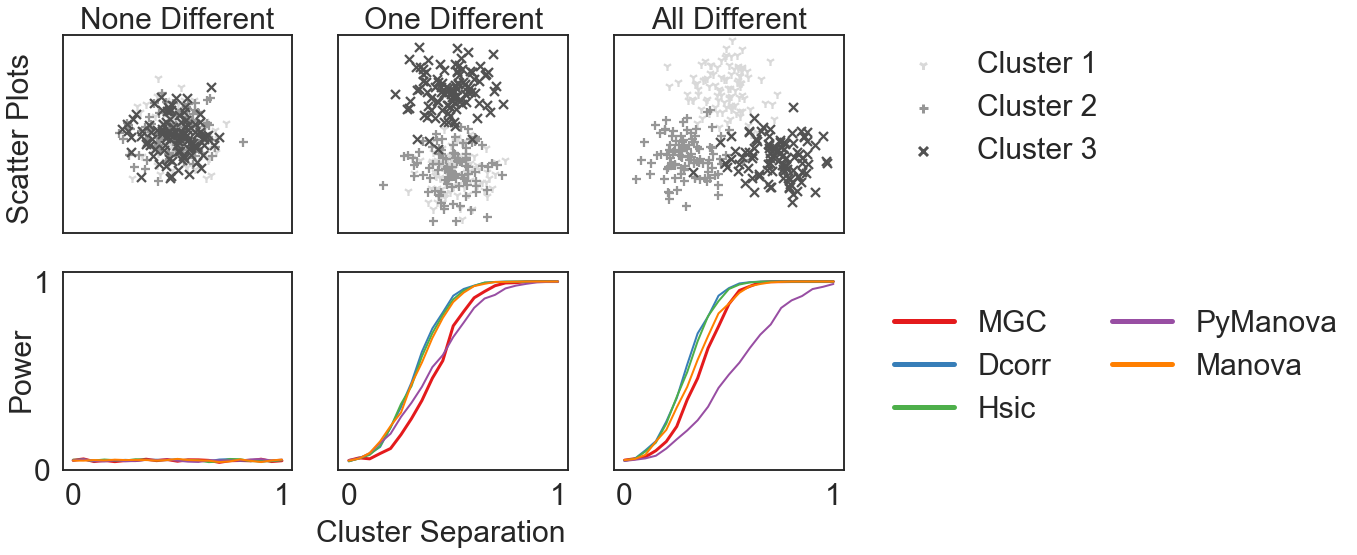

In [10]:
plot_power()